# Reinforcement Learning Project: Maze Extended

We create a maze for an agent to navigate out.

This tutorial is extended from this post.
- https://towardsdatascience.com/hands-on-introduction-to-reinforcement-learning-in-python-da07f7aaca88

However, here, we increased the number of moves that can be implemented
- Initially, there is only horizontal and vertical movement
- Now, we include diagonal movements

Also, we increase the map size to 8 by 8, and make the maze more complicated

# Import Library and Define Possible Actions

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Possible Action that can be done by the agent
ACTIONS = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1),
           'UL': (-1,-1), 'UR': (-1,1), 'DL': (1,-1), 'DR': (1,1)}

# Define Maze Class

## Initialize
1. Maze
2. Track movement history
3. Robot position, allowed states, etc

## Methods
1. is_allowed_move: Check if the agent is allowed to move in this direction
2. construct_allowed_states: Check where is the agent allowed to move
3. update_maze: Update the position of the agent
4. is_game_over: Check if the game is ended
5. give_reward: Compute the reward after each actions
6. get_state_and_reward: Get the position and reward after each action

In [50]:
class Maze(object):
    
    def __init__(self):

        #################################################################
        # Defining the Maze
        #################################################################
        self.size = 8
        
        self.maze = np.zeros((self.size, self.size))
        self.maze[0, 0] = 2
        self.maze[1, 5] = 1
        self.maze[0, 2] = 1
        self.maze[3, 6] = 1
        self.maze[4, 4] = 1
        self.maze[7, 4] = 1
        self.maze[2, 0:7] = 1
        self.maze[5, 1:8] = 1
        self.maze[5:7, 2] = 1
        self.maze[3, 2] = 1
        
        #################################################################
        # Keep track of movement history
        #################################################################
        self.movement_history = []
        
        #################################################################
        # Others
        #################################################################
        self.robot_position = (0, 0)     # current robot position
        self.steps = 0                   # contains num steps robot took
        self.allowed_states = None       # for now, this is none
        self.construct_allowed_states()  # not implemented yet
        
        
    #################################################################
    # Check if the agent is allowed to move in a specific direction
    #################################################################
    def is_allowed_move(self, state, action):
        y, x = state
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        
        # Moving off the board
        if ((y < 0) or 
            (x < 0) or 
            (y > self.size-1) or 
            (x > self.size-1)):
             return False
        
        # Moving into start position or empty space
        if self.maze[y, x] == 1:
            return False
        else:
            return True
        
    #################################################################
    # Find all the directions that the agent is allowed to move
    #################################################################
    def construct_allowed_states(self):
        allowed_states = {}
        for y, row in enumerate(self.maze):
            for x, col in enumerate(row):
                # Iterate through all valid spaces
                if self.maze[(y,x)] != 1:
                    allowed_states[(y,x)] = []
                    for action in ACTIONS:
                        if self.is_allowed_move((y, x), action):
                            allowed_states[(y,x)].append(action)
                            
        self.allowed_states = allowed_states
        
        
    #################################################################
    # Update the position of the agent within the maze
    #################################################################
    def update_maze(self, action):
        
        y, x = self.robot_position
        
        # Set the current position to empty
        self.maze[y, x] = 0
        
        # Find new position
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        self.robot_position = (y, x)
        self.maze[y, x] = 2
        self.steps += 1
        
        # Keep track of the path the agent moved
        self.movement_history.append(action)

        
    #################################################################
    # If the agent reach the end, ends the game
    #################################################################
    def is_game_over(self):
        if self.robot_position == (self.size-1, self.size-1):
            
            print('Actions required:', self.steps)
            #print(self.maze)
            print('Actions:', self.movement_history)
            
            return True
        return False
    
    #################################################################
    # At every step, give reward
    #################################################################
    def give_reward(self):
        if self.robot_position == (self.size-1, self.size-1):
            return 0
        else:
            return -1
        
    #################################################################
    # Update agent position and reward
    #################################################################
    def get_state_and_reward(self):
        return self.robot_position, self.give_reward()

# Define Agent Class

## Initialize
1. State history
2. Alpha - Learning rate
3. Random factor - Exploration rate
4. Reward table G

## Methods
1. init_reward: Generate a random reward table
2. choose_action: From the list of actions allowed, select one action to perform based on G and random factor
3. update_state_history: Update the state and reward
4. learn: Update the reward table G

In [51]:
class Agent(object):
    
    def __init__(self, states, alpha=0.15, random_factor=0.2):
        
        #################################################################
        # Define intial variables
        #################################################################
        self.state_history = [((0, 0), 0)] # State (x,y), reward
        self.alpha = alpha                 # Learning rate
        self.random_factor = random_factor # Exploration rate
        
        #################################################################
        # Initialize reward table
        #################################################################
        self.G = {}
        self.init_reward(states)
        
    #################################################################
    # Initalize reward table with values 0.1-1.0
    #################################################################
    def init_reward(self, states):
        for i, row in enumerate(states):
            for j, col in enumerate(row):
                self.G[(j,i)] = np.random.uniform(high=1.0, low=0.1)
                
    #################################################################
    # Choose direction to move
    #################################################################
    def choose_action(self, state, allowed_moves):
        next_move = None
        
        # Generate a random number 0 to 1
        n = np.random.random()
        
        # If n < self.random_factor -> Explore -> Go any random move
        if n < self.random_factor:
            next_move = np.random.choice(allowed_moves)
            
        # Eploit -> Go the path with highest expected reward
        else:
            # some really small random number
            maxG = -10e15
            
            # From all the allowed move
            # Find the one with the highest reward and go there
            for action in allowed_moves:
                new_state = tuple([sum(x) for x in zip(state, ACTIONS[action])])
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]
        return next_move
    
    #################################################################
    # Update the state history
    #################################################################
    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

        
    #################################################################
    # Update the reward table
    #################################################################
    def learn(self):
        target = 0

        for prev, reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward

        self.state_history = []
        
        # Reduce exploration rate over time
        self.random_factor -= 10e-5 # decrease random factor each episode of play
        print(self.random_factor)

# Check the inital reward table of the agent

In [52]:
maze = Maze()
robot = Agent(maze.maze, 
              alpha=0.1,         # Learning rate 
              random_factor=0.25 # Exploration rate
             )

robot.G

{(0, 0): 0.6489366292785688,
 (1, 0): 0.8976647233212731,
 (2, 0): 0.19734882917162302,
 (3, 0): 0.5382989752682286,
 (4, 0): 0.6731756645825353,
 (5, 0): 0.10751149803933363,
 (6, 0): 0.8896726987838321,
 (7, 0): 0.9446849507211953,
 (0, 1): 0.20216746821095946,
 (1, 1): 0.9708524246213145,
 (2, 1): 0.10058034701945508,
 (3, 1): 0.9150644162176949,
 (4, 1): 0.1151391510888404,
 (5, 1): 0.2006875014976346,
 (6, 1): 0.2414807070127054,
 (7, 1): 0.4411475624105945,
 (0, 2): 0.6977529002501349,
 (1, 2): 0.4177951107321505,
 (2, 2): 0.2505213817498441,
 (3, 2): 0.9850439844598288,
 (4, 2): 0.9509129258306095,
 (5, 2): 0.3887229652948174,
 (6, 2): 0.3622966681480312,
 (7, 2): 0.7481699757413784,
 (0, 3): 0.6131907746621947,
 (1, 3): 0.9145885521830388,
 (2, 3): 0.23597292041761014,
 (3, 3): 0.32089327811148016,
 (4, 3): 0.446788482798652,
 (5, 3): 0.46793619868147696,
 (6, 3): 0.4546705454045352,
 (7, 3): 0.4832063932732604,
 (0, 4): 0.27728702966130847,
 (1, 4): 0.486670895891518,
 (2, 4):

# Run main and let the agent learn from the environment

In [53]:
if __name__ == '__main__':
    
    # Create Maze and Agent
    maze = Maze()
    robot = Agent(maze.maze, 
                  alpha=0.1,         # Learning rate 
                  random_factor=0.25 # Exploration rate
                 )
    size = maze.size
    moveHistory = []

    # Loop for 3000 times
    for i in range(3000):
        print('\nLoop:', i+1)

        # Reinitialize the maze
        maze = Maze()
        
        # Conduct an action per turn
        while not maze.is_game_over():
            # Get the current state
            state, _ = maze.get_state_and_reward()
            
            # choose an action (explore or exploit)
            action = robot.choose_action(state, maze.allowed_states[state])
            
            # Update the maze according to the action
            maze.update_maze(action)
            
            # Get the new state and reward
            state, reward = maze.get_state_and_reward()
            
            # Update the robot memory with state and reward
            robot.update_state_history(state, reward)
            
            if maze.steps > 1000:
                # End the robot if it takes too long to find the goal
                # Set position to (5,5) to end the game
                maze.robot_position = (size-1,size-1)
        
        # Robot should learn after every episode
        robot.learn()
        
        # Get a history of number of steps taken to plot later
        moveHistory.append(maze.steps)


Loop: 1
Actions required: 1001
Actions: ['D', 'U', 'D', 'U', 'D', 'U', 'R', 'DL', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'DR', 'L', 'UR', 'DR', 'R', 'UR', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'UL', 'R', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'DL', 'UR', 'D', 'L', 'UR', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'L', 'DL', 'L', 'L', 'U', 'D', 'U', 'D', 'U', 'D', 'UR', 'DL', 'U', 'DR', 'L', 'U', 'R', 'DL', 'UR', 'DL', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'R', 'DL', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'DR', 'L', 'R', 'L', 'U', 'R', 'DL', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'R', 'DL', 'U', 'D', 'U', 'D', 'U', 'R', 'DL', 'U', 'D', 'U', 'DR', 'L', 'UR', 'DL', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'UR', 'DL', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'R', 'D', 'L', 'U', 'R', 'DL', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'UR', 'DL',

Actions required: 1001
Actions: ['D', 'U', 'D', 'U', 'D', 'UR', 'L', 'D', 'U', 'D', 'UR', 'L', 'D', 'U', 'DR', 'UL', 'D', 'U', 'D', 'UR', 'L', 'D', 'R', 'UL', 'D', 'U', 'R', 'L', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'R', 'L', 'D', 'U', 'D', 'U', 'D', 'U', 'R', 'L', 'DR', 'UL', 'D', 'U', 'D', 'U', 'DR', 'UL', 'D', 'U', 'D', 'R', 'UL', 'D', 'U', 'D', 'U', 'DR', 'L', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'DR', 'UL', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'R', 'L', 'D', 'U', 'D', 'UR', 'L', 'D', 'U', 'D', 'UR', 'L', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'UR', 'L', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'R', 'UL', 'R', 'D', 'UL', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'DR', 'UL', 'DR', 'UL', 'R', 'L', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'UR', 'L', 'D'

Actions required: 1001
Actions: ['DR', 'R', 'UR', 'R', 'R', 'R', 'L', 'R', 'L', 'DL', 'UR', 'DL', 'UR', 'R', 'L', 'R', 'L', 'DL', 'UR', 'R', 'L', 'DL', 'L', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'DL', 'UR', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'R', 'L', 'U', 'L', 'DR', 'UL', 'DR', 'UL', 'DL', 'UR', 'DL', 'UR', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'R', 'L', 'UL', 'DR', 'UL', 'L', 'D', 'L', 'R', 'UR', 'DR', 'U', 'L', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'R', 'L', 'DR', 'UL', 'DL', 'UR', 'R', 'L', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'L', 'D', 'U', 'R', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'R', 'D', 'UL', 'DR', 'UL', 'DR', 'U', 'L', 'DR', 'UL', 'DR', 'UL', 'DR', 'U', 'L', 'DR', 'UL', 'DL', 'L', 'R', 'L', 'UR', 'R', 'DR', 'UL', 'R', 'L', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DL', 'UR', 'DR', 'U', 'L', 'DR', 'UL', 'DR', 'R',

Actions required: 701
Actions: ['DR', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'UL', 'DR', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'U', 'DR', 'UR', 'DL', 'L', 'L', 'UL', 'DR', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'UL', 'DR', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'UL', 'DR', 'UL', 'D', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'L', 'R', 'L', 'R', 'UL', 'DR', 'R', 'UR', 'DL', 'L', 'R', 'L', 'R', 'L', 'R', 'U', 'DL', 'R', 'R', 'L', 'L', 'L', 'L', 'R', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'UR', 'DL', 'R', 'L', 'UR', 'D', 'L', 'R', 'L', 'R', 'UR', 'DL', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'UR', 'DL', 'R', 'L', 'UR', 'DL', '

Actions required: 1001
Actions: ['R', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'R', 'L', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'R', 'L', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'L', 'R', 'DR', 'UR', 'DR', 'UR', 'DR', 'DR', 'U', 'L', 'DR', 'UL', 'DR', 'UL', 'U', 'D', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'U', 'D', 'D', 'U', 'D', 'DL', 'L', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'UL', 'DR', 'U', 'D', 'U', 'D', 'U', 'D', 'R', 'L', 'U', 'L', 'DR', 'U', 'D', 'U', 'D', 'U', 'D', 'R', 'R', 'U', 'U', 'UL', 'DR', 'UL', 'R', 'D', 'UL', 'R', 'D', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'U', 'D', 'UL', 'DR', 'UL', 'DR', 'D', 'U', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'R', 'D', 'UL', 'DR', 'UL', 'DR', 'U', 'U', 'L', 'D', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'UR', 'DL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'U', 'D', 'DR', 'UL', 'DR', 'UL', 'DR', 'U

Actions required: 783
Actions: ['R', 'D', 'R', 'UL', 'DR', 'L', 'R', 'UL', 'DL', 'UR', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DL', 'UR', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'UL', 'DR', 'R', 'UR', 'R', 'R', 'R', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'D', 'U', 'U', 'D', 'U', 'DL', 'UR', 'D', 'D', 'U', 'D', 'U', 'U', 'D', 'U', 'L', 'R', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'D', 'U', 'U', 'D', 'L', 'UL', 'R', 'D', 'UR', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'DL', 'U', 'R', 'D', 'L', 'UR', 'D', 'L', 'UR', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'D', 'U', 'U', 'D', 'D', 'U', 'U', 'DL', 'U', 'R', 'D', 'U', 'D', 'U', 'D', 'U', 'L', 'R', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'DL', 'UR', 'DL', 'UR', 'D', 'U', 'L', 'R', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'D', 'U', 'UL', 'R', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'L', 'UR', 'D', 'U', 'D', 

Actions required: 32
Actions: ['R', 'DL', 'UR', 'DR', 'UR', 'R', 'R', 'DR', 'DR', 'D', 'DL', 'L', 'R', 'UR', 'DL', 'L', 'UL', 'DR', 'UL', 'L', 'DL', 'L', 'R', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'R', 'DR', 'R']
0.231900000000002

Loop: 182
Actions required: 29
Actions: ['R', 'DR', 'UR', 'R', 'R', 'R', 'DR', 'D', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'UL', 'DR', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'U', 'L', 'DR', 'R', 'U', 'DR']
0.231800000000002

Loop: 183
Actions required: 25
Actions: ['R', 'DR', 'UR', 'R', 'R', 'R', 'DR', 'D', 'D', 'DL', 'L', 'R', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'R']
0.23170000000000202

Loop: 184
Actions required: 29
Actions: ['R', 'DR', 'UR', 'R', 'R', 'R', 'DR', 'D', 'D', 'DL', 'L', 'UL', 'R', 'L', 'L', 'DL', 'L', 'UL', 'DR', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'UL', 'R', 'DR']
0.23160000000000203

Loop: 185
Actions required: 33
Actions: ['R', 'DR', 'UR', 'R', 'D', 'UR', 'R', 'DR', 'L', 'DR', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'UR

Actions required: 30
Actions: ['R', 'DR', 'UR', 'DR', 'UR', 'R', 'DR', 'UL', 'DR', 'D', 'D', 'U', 'D', 'DL', 'UR', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'D', 'R', 'DR', 'R', 'UR', 'R', 'R', 'DR']
0.22150000000000314

Loop: 286
Actions required: 34
Actions: ['R', 'L', 'DR', 'R', 'R', 'R', 'L', 'R', 'L', 'L', 'R', 'U', 'DR', 'UL', 'DR', 'UR', 'R', 'DR', 'D', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'R', 'R', 'DR']
0.22140000000000315

Loop: 287
Actions required: 30
Actions: ['R', 'DR', 'R', 'R', 'UR', 'R', 'R', 'D', 'D', 'D', 'D', 'L', 'UL', 'L', 'L', 'DL', 'L', 'L', 'U', 'DR', 'DL', 'DR', 'DR', 'R', 'UR', 'R', 'R', 'DL', 'UR', 'DR']
0.22130000000000316

Loop: 288
Actions required: 33
Actions: ['DR', 'UL', 'R', 'DL', 'R', 'U', 'DR', 'R', 'R', 'UL', 'DR', 'UR', 'R', 'DR', 'D', 'D', 'D', 'L', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UL', 'DR', 'R', 'UR', 'R', 'R', 'DR']
0.22120000000000317

Loop: 289
Actions required: 35
Actions: ['R', 'DR', 'R', 'R', 'U', '

Actions required: 39
Actions: ['DR', 'R', 'UL', 'DL', 'UR', 'DR', 'UL', 'DR', 'UR', 'DR', 'UL', 'DL', 'UR', 'DR', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'UR', 'DL', 'UR', 'DL', 'U', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'R', 'UL', 'DR', 'R']
0.20960000000000445

Loop: 405
Actions required: 29
Actions: ['DR', 'R', 'UR', 'DL', 'UR', 'DR', 'UR', 'DR', 'DR', 'U', 'D', 'D', 'D', 'L', 'UL', 'L', 'DL', 'UR', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'R', 'R']
0.20950000000000446

Loop: 406
Actions required: 26
Actions: ['DR', 'R', 'UR', 'DR', 'L', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UR', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'R']
0.20940000000000447

Loop: 407
Actions required: 37
Actions: ['DR', 'R', 'L', 'UL', 'DR', 'U', 'DR', 'UR', 'DR', 'L', 'R', 'UR', 'R', 'D', 'DR', 'U', 'D', 'D', 'DL', 'UL', 'L', 'DR', 'UL', 'L', 'D', 'L', 'L', 'DL', 'DR', 'DR', 'UL', 'DR', 'R', 'UR', 'DR', 'R', 'R']
0.20930000000000448

Loop: 408
Actions requir

Actions: ['DR', 'R', 'UR', 'R', 'R', 'DR', 'DR', 'D', 'D', 'L', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DL', 'UR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
0.19620000000000593

Loop: 539
Actions required: 34
Actions: ['DR', 'R', 'UR', 'DR', 'UR', 'L', 'R', 'DR', 'DR', 'UL', 'UR', 'D', 'L', 'DR', 'D', 'DL', 'R', 'L', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'L', 'R', 'UR', 'DR', 'UR', 'R', 'D']
0.19610000000000594

Loop: 540
Actions required: 23
Actions: ['D', 'R', 'R', 'UR', 'R', 'R', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
0.19600000000000595

Loop: 541
Actions required: 25
Actions: ['DR', 'R', 'UR', 'R', 'R', 'DR', 'DR', 'D', 'DL', 'UR', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'D', 'R', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
0.19590000000000596

Loop: 542
Actions required: 27
Actions: ['DR', 'R', 'UR', 'R', 'R', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'U', 'D', 'DL', 'D', 'R', 'DR', 'R', 'L', 'R', 'UR', 'DR', 'UR', 'DR'

Actions required: 25
Actions: ['DR', 'R', 'UR', 'DR', 'UR', 'DR', 'DR', 'D', 'DL', 'L', 'R', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'R', 'DR', 'U', 'DR']
0.1836000000000073

Loop: 665
Actions required: 28
Actions: ['DR', 'R', 'UR', 'DR', 'UR', 'DR', 'DR', 'U', 'D', 'D', 'DL', 'R', 'L', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DL', 'UR', 'R', 'DR', 'R']
0.18350000000000732

Loop: 666
Actions required: 31
Actions: ['DR', 'R', 'UR', 'DR', 'UR', 'DR', 'U', 'DR', 'U', 'D', 'D', 'D', 'DL', 'UR', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'UL', 'DR', 'DL', 'D', 'R', 'DR', 'UR', 'R', 'R', 'DR', 'R']
0.18340000000000733

Loop: 667
Actions required: 32
Actions: ['DR', 'R', 'UL', 'DR', 'UR', 'DR', 'UR', 'DL', 'UR', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'D', 'R', 'DR', 'UL', 'UL', 'D', 'R', 'DR', 'UR', 'R', 'R', 'R', 'DR']
0.18330000000000735

Loop: 668
Actions required: 27
Actions: ['DR', 'U', 'DR', 'UR', 'DR', 'UR', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'L', 

Actions required: 24
Actions: ['R', 'DR', 'UR', 'DR', 'UR', 'DR', 'DR', 'D', 'DL', 'UR', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'R']
0.1727000000000085

Loop: 774
Actions required: 22
Actions: ['R', 'DR', 'UR', 'DR', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'UR', 'DR']
0.17260000000000852

Loop: 775
Actions required: 23
Actions: ['R', 'DR', 'UR', 'DR', 'UR', 'R', 'D', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'R']
0.17250000000000854

Loop: 776
Actions required: 23
Actions: ['R', 'DR', 'UR', 'DR', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'U', 'DR']
0.17240000000000855

Loop: 777
Actions required: 31
Actions: ['D', 'UR', 'D', 'R', 'UR', 'D', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DL', 'UR', 'DR', 'UL', 'DR', 'UR', 'R', 'L', 'R', 'DR', 'R', 'R']
0.17230000000000856

Loop: 778


Loop: 904
Actions required: 22
Actions: ['DR', 'R', 'UR', 'R', 'R', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'R', 'DR', 'R']
0.15960000000000996

Loop: 905
Actions required: 23
Actions: ['DR', 'R', 'UR', 'DR', 'U', 'R', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'R', 'R']
0.15950000000000997

Loop: 906
Actions required: 31
Actions: ['DR', 'R', 'UR', 'R', 'R', 'DR', 'DR', 'D', 'DL', 'R', 'L', 'L', 'UL', 'L', 'DL', 'L', 'R', 'R', 'L', 'R', 'L', 'L', 'L', 'D', 'DR', 'DR', 'R', 'UR', 'R', 'DR', 'R']
0.15940000000000998

Loop: 907
Actions required: 24
Actions: ['DR', 'R', 'UR', 'DR', 'UR', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'R', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'R', 'DR', 'R']
0.15930000000001

Loop: 908
Actions required: 22
Actions: ['DR', 'R', 'UR', 'R', 'R', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'R', 'DR', 'R']
0.15920000000001

Loop: 909
Actions requi

Actions required: 31
Actions: ['D', 'R', 'R', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'U', 'D', 'DL', 'L', 'UL', 'DL', 'UR', 'DL', 'UR', 'DL', 'L', 'L', 'UL', 'D', 'D', 'DR', 'DR', 'R', 'UR', 'R', 'R', 'DR']
0.1484000000000112

Loop: 1017
Actions required: 30
Actions: ['DR', 'R', 'R', 'UR', 'R', 'DR', 'UR', 'DL', 'DR', 'D', 'DL', 'UR', 'DL', 'L', 'UL', 'DL', 'L', 'L', 'DL', 'U', 'D', 'DR', 'DR', 'R', 'UR', 'R', 'L', 'R', 'R', 'DR']
0.1483000000000112

Loop: 1018
Actions required: 24
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'DL', 'UR', 'R', 'R', 'R', 'DR']
0.1482000000000112

Loop: 1019
Actions required: 28
Actions: ['DR', 'R', 'UR', 'DR', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'L', 'UL', 'DR', 'UR', 'R', 'R', 'L', 'R', 'R', 'DR']
0.14810000000001122

Loop: 1020
Actions required: 24
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'D', 'L', 'L', 'UL', 'DL', 'L', 'L', 'DL', 'DR', '

Actions required: 24
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'U', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'R']
0.1374000000000124

Loop: 1127
Actions required: 22
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'R']
0.1373000000000124

Loop: 1128
Actions required: 23
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'L', 'U', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'R']
0.13720000000001242

Loop: 1129
Actions required: 22
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'R']
0.13710000000001243

Loop: 1130
Actions required: 25
Actions: ['DR', 'U', 'DR', 'R', 'R', 'UR', 'DR', 'U', 'D', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'R']
0.13700000000001245

Loop: 1131
Actions required: 27
Actions: ['DR', 'R', 'R', 

Actions required: 25
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'D', 'DR', 'L', 'R', 'R', 'UR', 'R', 'R', 'R', 'DR']
0.12480000000001376

Loop: 1253
Actions required: 28
Actions: ['DR', 'UL', 'DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'U', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'D', 'DR', 'R', 'UR', 'R', 'R', 'R', 'R', 'D']
0.12470000000001376

Loop: 1254
Actions required: 24
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'D', 'L', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'D', 'DR', 'R', 'UR', 'R', 'R', 'R', 'DR']
0.12460000000001376

Loop: 1255
Actions required: 25
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'D', 'DR', 'R', 'UR', 'R', 'R', 'R', 'L', 'R', 'DR']
0.12450000000001375

Loop: 1256
Actions required: 32
Actions: ['DR', 'R', 'L', 'L', 'R', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'D', 'L', 'UL', 'L', 'DL', 'L', 'L', 'UL', 'DR', 'DL', 'D', 'DR', 'R', 'UR', 'DL', 'UR', 'R', 'R', 

Actions required: 23
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'R', 'D']
0.11260000000001341

Loop: 1375
Actions required: 31
Actions: ['DR', 'R', 'L', 'U', 'DR', 'UR', 'DR', 'UR', 'DR', 'DR', 'D', 'DL', 'R', 'L', 'UR', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'L', 'R', 'UR', 'DR', 'UR', 'DR']
0.11250000000001341

Loop: 1376
Actions required: 26
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'U', 'D', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'R', 'L', 'DR', 'UR', 'DR']
0.1124000000000134

Loop: 1377
Actions required: 24
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'U', 'DR', 'D', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
0.1123000000000134

Loop: 1378
Actions required: 24
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'R', 'D', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'R', 'D']
0.11220

Actions required: 23
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'L', 'U', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'R', 'R']
0.10020000000001306

Loop: 1499
Actions required: 23
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'D', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'R', 'R']
0.10010000000001305

Loop: 1500
Actions required: 23
Actions: ['DR', 'R', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'U', 'R', 'DR']
0.10000000000001305

Loop: 1501
Actions required: 26
Actions: ['DR', 'R', 'R', 'R', 'UR', 'R', 'D', 'DR', 'D', 'D', 'L', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'UR', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'R', 'R']
0.09990000000001305

Loop: 1502
Actions required: 25
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'UL', 'R', 'D', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'R', 'R']
0.09980000000001304

Loop: 1503
Actions required: 25
Acti

Loop: 1636
Actions required: 31
Actions: ['DR', 'R', 'R', 'UR', 'R', 'R', 'DR', 'UL', 'DR', 'D', 'D', 'U', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'UR', 'DL', 'R', 'L', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'R', 'R', 'DR']
0.08640000000001266

Loop: 1637
Actions required: 24
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'R', 'L', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'R', 'R', 'DR']
0.08630000000001266

Loop: 1638
Actions required: 26
Actions: ['DR', 'R', 'R', 'U', 'DR', 'UR', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'L', 'D', 'L', 'L', 'DL', 'DR', 'L', 'R', 'DR', 'UR', 'R', 'R', 'DR', 'R']
0.08620000000001266

Loop: 1639
Actions required: 26
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'UR', 'D', 'D', 'D', 'D', 'L', 'L', 'UL', 'DL', 'U', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'R', 'R', 'DR']
0.08610000000001265

Loop: 1640
Actions required: 24
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'UR', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'R

Actions required: 23
Actions: ['DR', 'R', 'R', 'R', 'UR', 'R', 'DR', 'D', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'R', 'R', 'DR']
0.07500000000001233

Loop: 1751
Actions required: 26
Actions: ['DR', 'U', 'DR', 'UR', 'DR', 'UR', 'R', 'DR', 'D', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'UL', 'DR', 'DL', 'DR', 'DR', 'UR', 'R', 'R', 'R', 'DR']
0.07490000000001233

Loop: 1752
Actions required: 26
Actions: ['D', 'R', 'R', 'R', 'R', 'UR', 'R', 'DR', 'D', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DL', 'UR', 'DR', 'UR', 'R', 'R', 'R', 'DR']
0.07480000000001233

Loop: 1753
Actions required: 23
Actions: ['DR', 'R', 'R', 'UR', 'R', 'R', 'DR', 'D', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'R', 'R', 'DR']
0.07470000000001233

Loop: 1754
Actions required: 23
Actions: ['DR', 'R', 'R', 'R', 'UR', 'R', 'DR', 'D', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'R', 'R', 'DR']
0.07460000000001232

Loop: 1755
Actions required: 2

Loop: 1886
Actions required: 23
Actions: ['R', 'DR', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'UL', 'D', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'R']
0.061400000000011945

Loop: 1887
Actions required: 26
Actions: ['R', 'DR', 'UL', 'DR', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'R', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'R']
0.06130000000001194

Loop: 1888
Actions required: 24
Actions: ['R', 'DR', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'UL', 'DR', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'R']
0.06120000000001194

Loop: 1889
Actions required: 22
Actions: ['R', 'DR', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'R', 'R']
0.061100000000011936

Loop: 1890
Actions required: 24
Actions: ['R', 'DR', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'R', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'R', 'DR', 'R']
0.061000000000011934

Loop: 1891
Actions req

Actions required: 22
Actions: ['R', 'DR', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'R', 'DR', 'R']
0.04960000000001161

Loop: 2005
Actions required: 22
Actions: ['R', 'DR', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'R', 'DR', 'R']
0.049500000000011604

Loop: 2006
Actions required: 22
Actions: ['R', 'DR', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'R', 'DR', 'R']
0.0494000000000116

Loop: 2007
Actions required: 24
Actions: ['R', 'DR', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'L', 'R', 'UR', 'R', 'DR', 'R']
0.0493000000000116

Loop: 2008
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'R', 'DR', 'R']
0.049200000000011596

Loop: 2009
Actions required: 22
Actions: ['R', 'DR', 'R', 'UR', 'R', 'DR', '

Actions required: 27
Actions: ['R', 'DR', 'UL', 'DR', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'D', 'L', 'UR', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'UR', 'DR']
0.03850000000001129

Loop: 2116
Actions required: 22
Actions: ['DR', 'R', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'UR', 'DR']
0.038400000000011286

Loop: 2117
Actions required: 25
Actions: ['DR', 'R', 'R', 'UR', 'R', 'DR', 'DR', 'U', 'D', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'D', 'R', 'DR', 'UR', 'R', 'DR', 'UR', 'DR']
0.03830000000001128

Loop: 2118
Actions required: 22
Actions: ['DR', 'R', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'UR', 'DR']
0.03820000000001128

Loop: 2119
Actions required: 22
Actions: ['DR', 'R', 'R', 'UR', 'R', 'DR', 'DR', 'D', 'DL', 'L', 'UL', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'UR', 'DR']
0.03810000000001128

Loop: 2120
Actions required: 22
A

0.0285000000000111

Loop: 2216
Actions required: 22
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'UR', 'DR']
0.0284000000000111

Loop: 2217
Actions required: 24
Actions: ['DR', 'R', 'R', 'R', 'L', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'UR', 'DR']
0.0283000000000111

Loop: 2218
Actions required: 22
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'UR', 'DR']
0.0282000000000111

Loop: 2219
Actions required: 23
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'UL', 'D', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'UR', 'DR']
0.028100000000011102

Loop: 2220
Actions required: 22
Actions: ['DR', 'R', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'L', 'DL', 'L', 'DL', 'DR', 'DR', 'UR', 'R', 'DR', 'UR', 'DR']
0.028000000000011103

Loop: 2221
Actions required: 2

Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
0.014700000000011183

Loop: 2354
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
0.014600000000011184

Loop: 2355
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
0.014500000000011184

Loop: 2356
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
0.014400000000011185

Loop: 2357
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
0.014300000000011186

Loop: 2358
Actions required: 25
Actions: ['R', 'DR', 'R', 'U', 'DR', 'L

Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.0009999999999887833

Loop: 2511
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.0010999999999887833

Loop: 2512
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.0011999999999887834

Loop: 2513
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.0012999999999887834

Loop: 2514
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.0013999999999887835

Loop: 2515
Actions required: 22
Actions: ['R', 'DR', 'R', 'R'

Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.01639999999998874

Loop: 2665
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.01649999999998874

Loop: 2666
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.01659999999998874

Loop: 2667
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.016699999999988738

Loop: 2668
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.016799999999988737

Loop: 2669
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 

Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.0329999999999887

Loop: 2831
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.0330999999999887

Loop: 2832
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.033199999999988704

Loop: 2833
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.03329999999998871

Loop: 2834
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.03339999999998871

Loop: 2835
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR

-0.04679999999998909

Loop: 2969
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.046899999999989096

Loop: 2970
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.0469999999999891

Loop: 2971
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.0470999999999891

Loop: 2972
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.047199999999989105

Loop: 2973
Actions required: 22
Actions: ['R', 'DR', 'R', 'R', 'UR', 'DR', 'DR', 'D', 'DL', 'UL', 'L', 'DL', 'L', 'L', 'DL', 'DR', 'DR', 'R', 'UR', 'DR', 'UR', 'DR']
-0.04729999999998911

Loop: 2974
Actions required: 22
Action

# Plot Steps Rquired before game over or terminated

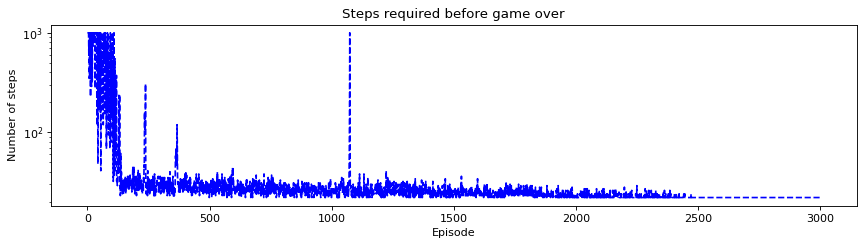

In [66]:
plt.figure(figsize=(13, 3), dpi=80)
plt.semilogy(moveHistory, "b--")
plt.title('Steps required before game over')
plt.ylabel('Number of steps')
plt.xlabel('Episode')
plt.show()

# Check the updated reward table of the agent

In [55]:
robot.G

{(0, 0): -41.61061445916852,
 (1, 0): -23.40674596029139,
 (2, 0): 0.21706722217735358,
 (3, 0): -9.211443029725553,
 (4, 0): -7.5832380559996935,
 (5, 0): -6.0000000000000036,
 (6, 0): -6.567811236115789,
 (7, 0): -6.807324096919709,
 (0, 1): -20.000000000000014,
 (1, 1): -20.999377521030702,
 (2, 1): 0.26067560818188323,
 (3, 1): -8.672624980297543,
 (4, 1): -7.0000000000000036,
 (5, 1): 0.43314455315379874,
 (6, 1): -5.0000000000000036,
 (7, 1): -5.30167796380027,
 (0, 2): 0.26624711486486113,
 (1, 2): -19.000000000000014,
 (2, 2): 0.4711267138621843,
 (3, 2): 0.432768991206806,
 (4, 2): -8.000000000000007,
 (5, 2): 0.8848596055006694,
 (6, 2): 0.1732404678810696,
 (7, 2): -4.0000000000000036,
 (0, 3): -19.61184135495732,
 (1, 3): -18.000000000000014,
 (2, 3): 0.7163917370639707,
 (3, 3): -9.79487562292514,
 (4, 3): -9.000000000000007,
 (5, 3): 0.30377078053827766,
 (6, 3): -3.4670128272763128,
 (7, 3): -3.0000000000000018,
 (0, 4): -18.197483606047104,
 (1, 4): -17.000000000000014,

# We visualize the reward table across the environment (x,y)
We set the "walls" to be -10000

Note:
- Only the goal is 0
- The other path will always be a negative value

In [56]:
matrix_G = np.zeros((size,size))

for i in robot.G:
    x, y = i
    reward = robot.G[i]
    matrix_G[x,y] = reward

matrix_G = np.round(matrix_G,3)
matrix_G[matrix_G>0] = -10000

np.set_printoptions(suppress=True)
print(matrix_G)

[[   -41.611    -20.    -10000.       -19.612    -18.197    -16.
     -17.365    -20.958]
 [   -23.407    -20.999    -19.       -18.       -17.    -10000.
     -15.       -16.151]
 [-10000.    -10000.    -10000.    -10000.    -10000.    -10000.
  -10000.       -14.   ]
 [    -9.211     -8.673 -10000.        -9.795    -10.       -11.
  -10000.       -13.   ]
 [    -7.583     -7.        -8.        -9.    -10000.       -12.12
     -12.       -14.351]
 [    -6.    -10000.    -10000.    -10000.    -10000.    -10000.
  -10000.    -10000.   ]
 [    -6.568     -5.    -10000.        -3.467     -2.        -1.33
      -0.        -0.013]
 [    -6.807     -5.302     -4.        -3.    -10000.        -1.
      -0.243      0.   ]]


# Print the best action set

In [57]:
maze.movement_history

['R',
 'DR',
 'R',
 'R',
 'UR',
 'DR',
 'DR',
 'D',
 'DL',
 'UL',
 'L',
 'DL',
 'L',
 'L',
 'DL',
 'DR',
 'DR',
 'R',
 'UR',
 'DR',
 'UR',
 'DR']

# Plot the reward table as a color map

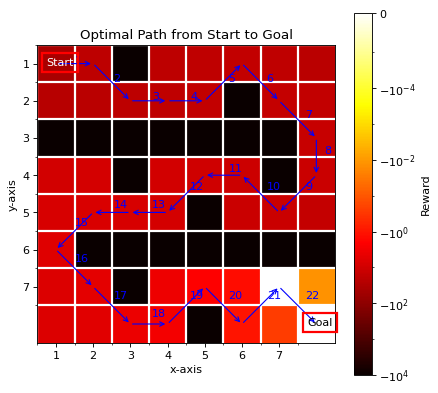

In [60]:
#################################################################
# Compute parameters to plot log scale color bar
#################################################################
logthresh = 5
vmin = np.min(matrix_G)
vmax = np.max([np.max(matrix_G), 1])
maxlog=int(np.ceil(np.log10(vmax) ))
minlog=int(np.ceil(np.log10(-vmin) ))

#################################################################
# Plot color map
#################################################################
plt.figure(figsize=(6, 6), dpi=80)
plt.imshow(matrix_G, 
           cmap='hot', 
           #interpolation='nearest',
           norm=matplotlib.colors.SymLogNorm(10**-logthresh)
          )

#################################################################
# Plot action path from start to goal
#################################################################
action_list = maze.movement_history

start_x = 0
start_y = 0
for i, action in enumerate(action_list):
    end_x = start_x + ACTIONS[action][0]
    end_y = start_y + ACTIONS[action][1]
    
    plt.annotate('', 
                 xytext=(end_y, end_x),
                 xy=(start_y, start_x), 
                 arrowprops=dict(arrowstyle="<-", color='blue'))
    
    x_mid = (start_x+end_x)/2
    y_mid = (start_y+end_y)/2
    
    plt.annotate(i+1, 
                 xytext=(y_mid, x_mid),
                 xy=(y_mid, x_mid), 
                 color='blue',
                 textcoords='offset points')
    
    start_x = end_x
    start_y = end_y

plt.text(size-0.25, size+0.05, 'Goal', 
         bbox=dict(fill=False, edgecolor='red', linewidth=2))
plt.text(-0.25, 0.05, 'Start', color='white', 
         bbox=dict(fill=False, edgecolor='red', linewidth=2))
    
#################################################################
# Generate logarithmic ticks 
#################################################################
tick_locations=([-(10**x) for x in range(minlog,-logthresh-1,-2)]
                +[0.0]
                +[(10**x) for x in range(-logthresh,maxlog+1,2)])

#################################################################
# Generating grid for clearer illustration
#################################################################
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, size, 1))
ax.set_yticks(np.arange(0, size, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, size+1, 1))
ax.set_yticklabels(np.arange(1, size+1, 1))

# Minor ticks
ax.set_xticks(np.arange(-.5, size, 1), minor=True)
ax.set_yticks(np.arange(-.5, size, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

#################################################################
# Add description
#################################################################
plt.title('Optimal Path from Start to Goal')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

cbar = plt.colorbar(ticks=tick_locations)
cbar.set_label('Reward')

plt.show()